Let's review MINIAOD(SIM) usage on US disk sites (T1 and T2).

We need a breakdown of

Campaign name | size on US disks | last accessed

After that, we can choose where to put the cut and lift the rules for unused or super old campaigns.


In [167]:
#import

from datetime import datetime, timedelta
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [168]:
TODAY = datetime.today()
# TODAY = TODAY - timedelta(days=1)# uncomment to use YESTERDAY as today
TODAY = TODAY.strftime('%Y-%m-%d')

In [169]:
#pandas display settings

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [170]:
#HDFS import paths

HDFS_RUCIO_CONTENTS = "/project/awg/cms/rucio/{}/contents/part*.avro".format(TODAY)
HDFS_RUCIO_REPLICAS = "/project/awg/cms/rucio/{}/replicas/part*.avro".format(TODAY)
HDFS_RUCIO_DIDS     = "/project/awg/cms/rucio/{}/dids/part*.avro".format(TODAY)
HDFS_RUCIO_LOCKS    = "/project/awg/cms/rucio/{}/locks/part*.avro".format(TODAY)
HDFS_RUCIO_RSES     = "/project/awg/cms/rucio/{}/rses/part*.avro".format(TODAY)
HDFS_RUCIO_RULES     = "/project/awg/cms/rucio/{}/rules/part*.avro".format(TODAY)

In [171]:
# Get the list of desired Rses - T1 and T2 Rses at US sites

df_rses = spark.read.format('avro').load(HDFS_RUCIO_RSES)\
    .withColumn('rse_id', F.lower(F.hex(F.col('ID'))))\
    .withColumnRenamed('RSE', 'rse_name')\
    .withColumnRenamed('RSE_TYPE', 'rse_type')\
    .select(['rse_name', 'rse_id', 'rse_type'])

df_us_disk_rses = df_rses.filter( \
                            ( ~ F.col('rse_name').contains("_Tape") ) & \
                            ( ~ F.col('rse_name').contains("T3_") ) & \
                            ( ~ F.col('rse_name').contains("_Test") ) & \
                            ( ~ F.col('rse_name').contains("_Temp") ) & \
                            ( ~ F.col('rse_name').contains("_Ceph") ) &\
                            ( F.col('rse_name').contains("US") ) \
                           )


In [172]:
# df_rses.toPandas()

In [173]:
# MINIAOD(SIM) files with locks

df_locks = spark.read.format('avro').load(HDFS_RUCIO_LOCKS) \
    .filter(F.col("STATE") == 'O') \
    .filter(F.col('NAME').contains('MINIAOD')) \
    .withColumnRenamed("NAME", "file_name") \
    .withColumn('file_size', F.col('BYTES').cast(T.LongType())) \
    .withColumn('rule', F.lower(F.hex(F.col('RULE_ID')))) \
    .withColumn('rse_id', F.lower(F.hex(F.col('RSE_ID')))) \
    .withColumn("created_date", F.from_unixtime(F.col('created_at')/1000).cast(T.DateType())) \
    .withColumn("rule_age_days", F.datediff(F.current_date(), F.col('created_date'))) \
    .select(["file_name", "file_size", "rule", "rse_id", "created_date", "rule_age_days"])

In [174]:
# df_locks.limit(5).toPandas()

In [175]:
df_locks_miniaod_us = df_us_disk_rses.alias("rses")\
                            .join(df_locks.alias("locks"), F.col("rses.rse_id")==F.col("locks.rse_id"))\
                            .select(["rses.rse_name", "rses.rse_id", "locks.file_name", "locks.file_size", "locks.rule"])

In [176]:
df_locks_miniaod_us.limit(5).toPandas()

rse_name                            rse_id  \
0  T1_US_FNAL_Disk  087ee3383b9d45f6b31814af07b2c56d   
1    T2_US_Florida  9cab8c2f425b4de8ba03a4f430722ffc   
2   T2_US_Nebraska  a6981dee6ed14b7c8c1b0e9fe7644401   
3  T1_US_FNAL_Disk  087ee3383b9d45f6b31814af07b2c56d   
4  T1_US_FNAL_Disk  087ee3383b9d45f6b31814af07b2c56d   

                                                                                                                                                                                                    file_name  \
0  /store/mc/RunIISummer20UL17MiniAODv2/ZLLGJets_MonoPhoton_MLL-4to30_PtG-15to130_TuneCP5_13TeV-amcatnloFXFX-pythia8/MINIAODSIM/106X_mc2017_realistic_v9-v2/2520000/516870D5-1E71-D34F-9E4E-D834C5687AAD.root   
1     /store/mc/RunIISummer20UL16MiniAODv2/BdToJpsiKstar_BMuonFilter_SoftQCDnonD_TuneCP5_13TeV-pythia8-evtgen/MINIAODSIM/106X_mcRun2_asymptotic_v17_ext1-v2/2430000/843DDCB6-2F03-3443-8D93-834BECDED828.root   
2                                  /store/mc/RunIISummer20UL17MiniAOD/TTToSemiLeptonic_TuneCP5up_13TeV-powheg-pythia8/MINIAODSIM/106X_mc2017_realistic_v6-v2/120000/E7DB7788-24CC-3D40-B5F1-9B307F9D835C.root   
3                               /store/mc/RunIISummer20UL17MiniAOD/ZToJPsiG_JPsiToMuMu_TuneCP5_13TeV-madgraph-pythia8/MINIAODSIM/106X_mc2017_realistic_v6-v2/120000/5D9DFF09-B97C-7E47-9B67-9AECB12C230E.root   
4                                                                                                    /store/data/Run2018D/EGamma/MINIAOD/12Nov2019_UL2018-v8/280002/E3BADDD4-2AA1-934F-BCC0-D614904D81FC.root   

    file_size                              rule  
0  2534772263  0e91bccd10ee44a4b850793ad27f92d6  
1  3777341936  ea862a4868fb4f10a2312ee521962af2  
2  4089853207  e608c12a42e2491d83a9536955ec8246  
3  3744030645  e56c28dbd89242c68d30f9d92457ee98  
4  4227918601  3161d8d6579c4a4e8f74f22f74a459e2

In [177]:

# df_replicas = spark.read.format('avro').load(HDFS_RUCIO_REPLICAS)\
#                     .withColumn('rse_id', F.lower(F.hex(F.col('RSE_ID'))))\
#                     .withColumnRenamed('NAME', 'file_name')\
#                     .alias("replicas")\
#                     .join(
#                         df_rses.alias("rse_name"),
#                         F.col("rse_name.rse_id")==F.col("replicas.rse_id")
#                     )\
#                     .select(['replicas.rse_id',  'rse_name', 'file_name',])

In [178]:
# df_replicas.show(20, False)

In [179]:
#Check the latest access for replica of miniaod(sim) in concern
#We are ignoring last access - so skip this

# df_locked_miniaods_us_with_last_access = df_locks_miniaod_us.alias("mini_lock")\
#                                                             .join(df_replicas.alias("replicas"),
#                                                                   [F.col("replicas.file_name")==F.col("mini_lock.file_name"), F.col("replicas.rse_id")==F.col("mini_lock.rse_id")]
#                                                                  )\
#                                                             .select(["mini_lock.rse_name", "mini_lock.rse_id", "mini_lock.file_name", "mini_lock.file_size", "mini_lock.rule", "replicas.accessed_at"])

In [180]:
# df_locked_miniaods_us_with_last_access.limit(5).toPandas()

In [181]:
#Get file and block name maps

df_file_block_map = spark.read.format('avro').load(HDFS_RUCIO_CONTENTS)\
                    .filter(F.col('CHILD_TYPE')=='F')\
                    .withColumnRenamed('NAME', 'block_name')\
                    .withColumnRenamed('CHILD_NAME', 'file_name')\
                    .select(['block_name', "file_name"])

In [182]:
df_blocks_miniaod_us = df_locks_miniaod_us.alias("mini_files")\
                                    .join(df_file_block_map.alias("file_block_map"),
                                         F.col("mini_files.file_name")==F.col("file_block_map.file_name")
                                         )\
                                    .withColumnRenamed('rse_name', 'us_disk_rse')\
                                    .select(["us_disk_rse", "mini_files.rse_id", "mini_files.file_name", "mini_files.file_size", "mini_files.rule", "file_block_map.block_name"])

In [183]:
# df_blocks_miniaod_us.limit(5).toPandas()

In [184]:
df_block_dataset_map = spark.read.format('avro').load(HDFS_RUCIO_CONTENTS)\
                    .filter(F.col('CHILD_TYPE')=='D')\
                    .withColumnRenamed('NAME', 'dataset_name')\
                    .withColumnRenamed('CHILD_NAME', 'block_name')\
                    .select(['dataset_name', "block_name"])

In [185]:

#group by campaign, tier etc

df_blocks_miniaod_us_campaign = df_blocks_miniaod_us.na.fill(0)\
                                    .withColumn('dataset_name', F.split(F.col('block_name'), '#').getItem(0))\
                                    .withColumn('tier', F.split(F.col('dataset_name'), '/').getItem(3))\
                                    .withColumn('brute_campaign', F.split(F.col('dataset_name'), '/').getItem(2))\
                                    .withColumn('short_campaign', F.split(F.col('brute_campaign'), '-').getItem(0))\
                                    .withColumn('campaign',
                                               F.when(F.col("tier")=="MINIAOD", F.col("brute_campaign"))\
                                                .otherwise(F.col("short_campaign"))
                                               )\
                                    .dropDuplicates(["file_name"])\
                                    .select(["campaign", "file_name", "dataset_name", "file_size"])
#                                     .withColumn("accessed_at_date", F.from_unixtime(F.col('accessed_at')/1000).cast(T.DateType()))

In [218]:
top_20_us_campaigns = df_blocks_miniaod_us_campaign\
             .groupby(['campaign'])\
             .agg(F.sum("file_size").alias("campaign_size"))\
             .sort(F.col("campaign_size").desc())\
             .limit(20)

# top_20_us_campaigns.show(20, False)

In [225]:
temp_d = top_20_us_campaigns.toPandas().to_dict()
campaign_size_dict = {}
for i in range(20):
    campaign_size_dict[temp_d['campaign'][i]] = temp_d['campaign_size'][i]
    
campaigns_list = list(campaign_size_dict.keys())

In [224]:
top20_campaign_files = top_20_us_campaigns.alias("top20")\
                        .join(
                            df_blocks_miniaod_us_campaign.alias("all"),
                            F.col("top20.campaign")==F.col("all.campaign")
                        )\
                        .select(["top20.campaign", "campaign_size", "file_name", "dataset_name", "file_size"])

In [260]:
other_locked_replicas_for_top20 = top20_campaign_files.alias("campaign_files")\
                            .join(
                                df_locks.alias("replica"),
                                F.col("campaign_files.file_name")==F.col("replica.file_name")
                            )


dataset_sizes = top20_campaign_files\
                    .dropDuplicates(["file_name"])\
                    .groupby("dataset_name")\
                    .agg(F.sum("file_size").alias("dataset_size"))

 #insert different dataset name here
for campaign in campaigns_list:
    tape_replicas = other_replica_for_top20\
                            .filter(F.col("campaign")==campaign)\
                            .groupby(["dataset_name"])\
                            .agg(
                                (F.sum("file_size")/1000000000).alias("size_on_rses_gb"),
                                F.collect_set(F.col("rse_name")).alias("rse_set")
                            )\
                            .withColumn("rses", F.concat_ws(",", F.col("rse_set")))\
                            .withColumn("on_tape", F.col("rses").contains("Tape"))\
                            .select(["dataset_name", "size_on_rses_gb", "rses", "on_tape"])
    tape_rep_dataset_size = tape_replicas.join(dataset_sizes)
    pd_rep = tape_replicas.toPandas()
    
    meta_df['campaign'].append(campaign)
    meta_df['campaign_size'].append(campaign_size_dict[campaign])
    meta_df['total_dataset_count'].append(pd_rep.shape[0])
    meta_df['datasets_on_tape'].append(pd_rep[pd_rep.on_tape == True].shape[0])
    meta_df['datasets_not_on_tape'].append(pd_rep[pd_rep.on_tape != True].shape[0])
    
    pd_rep.to_csv(f"Campaigns/{campaign}.csv", index=False)

# meta_df['sum_dataset_sizes'].append(0)
# meta_df['dataset_on_tape_size'].append()
# meta_df['dataset_not_on_tape_size'].append(0)

In [265]:
tape_replicas = other_replica_for_top20\
                        .filter(F.col("campaign")=="RunIISummer20UL18MiniAODv2")\
                        .groupby(["dataset_name"])\
                        .agg(
                            (F.sum("file_size")/1000000000).alias("size_on_rses_gb"),
                            F.collect_set(F.col("rse_name")).alias("rse_set")
                        )\
                        .withColumn("rses", F.concat_ws(",", F.col("rse_set")))\
                        .withColumn("on_tape", F.col("rses").contains("Tape"))\
                        .select(["dataset_name", "size_on_rses_gb", "rses", "on_tape"])
tape_rep_dataset_size = tape_replicas.join(dataset_sizes)

In [267]:
pd_rep = tape_rep_dataset_size.toPandas()

22/11/28 18:06:34 WARN BlockManager: Failed to fetch remote block taskresult_91988 from [BlockManagerId(1279, ithdp4024.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:35 WARN BlockManager: Failed to fetch remote block taskresult_91968 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:37 WARN BlockManager: Failed to fetch remote block taskresult_91967 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:38 WARN BlockManager: Failed to fetch remote block taskresult_91984 from [BlockManagerId(1290, ithdp3105.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:39 WARN TaskSetManager: Lost task 120.0 in stage 2583.0 (TID 91976) (ithdp5007.cern.ch executor 1278): TaskResultLost (result lost from block manager)
22/11/28 18:06:39 WARN BlockManager: Failed to fetch remote block taskresult_91987 from [BlockManagerId(1291, ithdp4021.cern.ch, 5101, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apac

22/11/28 18:06:41 WARN BlockManager: Failed to fetch remote block taskresult_91989 from [BlockManagerId(1290, ithdp3105.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:41 WARN BlockManager: Failed to fetch remote block taskresult_92002 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:43 WARN BlockManager: Failed to fetch remote block taskresult_91997 from [BlockManagerId(1279, ithdp4024.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:44 WARN BlockManager: Failed to fetch remote block taskresult_91999 from [BlockManagerId(1290, ithdp3105.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:45 WARN BlockManager: Failed to fetch remote block taskresult_92003 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:46 WARN BlockManager: Failed to fetch remote block taskresult_91994 from [BlockManagerId(1301, ithdp3104.cern.ch, 5103, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:47 WARN TaskSetManager: Lost task 125.0 in stage 2583.0 (TID 91981) (ithdp5007.cern.ch executor 1278): TaskResultLost (result lost from block manager)
22/11/28 18:06:47 WARN BlockManager: Failed to fetch remote block taskresult_91971 from [BlockManagerId(1278, ithdp5007.cern.ch, 5101, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apac

22/11/28 18:06:50 WARN BlockManager: Failed to fetch remote block taskresult_91995 from [BlockManagerId(1279, ithdp4024.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:51 WARN BlockManager: Failed to fetch remote block taskresult_92011 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:52 WARN TaskSetManager: Lost task 152.0 in stage 2583.0 (TID 92008) (ithdp5005.cern.ch executor 1300): TaskResultLost (result lost from block manager)
22/11/28 18:06:53 WARN BlockManager: Failed to fetch remote block taskresult_92010 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apac

22/11/28 18:06:53 WARN BlockManager: Failed to fetch remote block taskresult_91992 from [BlockManagerId(1301, ithdp3104.cern.ch, 5103, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:54 WARN BlockManager: Failed to fetch remote block taskresult_92014 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:56 WARN BlockManager: Failed to fetch remote block taskresult_92017 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:57 WARN BlockManager: Failed to fetch remote block taskresult_92019 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:58 WARN BlockManager: Failed to fetch remote block taskresult_92016 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:06:59 WARN BlockManager: Failed to fetch remote block taskresult_92020 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:02 WARN BlockManager: Failed to fetch remote block taskresult_91915 from [BlockManagerId(1309, ithdp5005.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:04 WARN BlockManager: Failed to fetch remote block taskresult_91913 from [BlockManagerId(1309, ithdp5005.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:05 WARN BlockManager: Failed to fetch remote block taskresult_91912 from [BlockManagerId(1309, ithdp5005.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:06 WARN TaskSetManager: Lost task 165.0 in stage 2583.0 (TID 92021) (ithdp5005.cern.ch executor 1300): TaskResultLost (result lost from block manager)
22/11/28 18:08:06 WARN TaskSetManager: Lost task 57.0 in stage 2583.0 (TID 91913) (ithdp5005.cern.ch executor 1309): TaskResultLost (result lost from block manager)
22/11/28 18:08:06 WARN TaskSetManager: Lost task 170.0 in stage 2583.0 (TID 92029) (ithdp5005.cern.ch executor 1300): TaskResultLost (result lost from block manager)
22/11/28 18:08:07 WARN BlockManager: Failed to fetch remote block taskresult_92024 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(Block

22/11/28 18:08:09 WARN BlockManager: Failed to fetch remote block taskresult_91957 from [BlockManagerId(1311, ithdp5005.cern.ch, 5108, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:10 WARN BlockManager: Failed to fetch remote block taskresult_91938 from [BlockManagerId(1310, ithdp5005.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:13 WARN BlockManager: Failed to fetch remote block taskresult_91939 from [BlockManagerId(1310, ithdp5005.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:13 WARN TaskSetManager: Lost task 112.1 in stage 2583.0 (TID 92025) (ithdp5005.cern.ch executor 1309): TaskResultLost (result lost from block manager)
22/11/28 18:08:13 WARN TaskSetManager: Lost task 83.0 in stage 2583.0 (TID 91939) (ithdp5005.cern.ch executor 1310): TaskResultLost (result lost from block manager)
22/11/28 18:08:14 WARN BlockManager: Failed to fetch remote block taskresult_91936 from [BlockManagerId(1310, ithdp5005.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apa

22/11/28 18:08:16 WARN BlockManager: Failed to fetch remote block taskresult_92028 from [BlockManagerId(1309, ithdp5005.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:17 WARN BlockManager: Failed to fetch remote block taskresult_91960 from [BlockManagerId(1311, ithdp5005.cern.ch, 5108, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:19 WARN BlockManager: Failed to fetch remote block taskresult_92005 from [BlockManagerId(1313, ithdp5005.cern.ch, 5109, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:20 WARN BlockManager: Failed to fetch remote block taskresult_92051 from [BlockManagerId(1279, ithdp4024.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:21 WARN TaskSetManager: Lost task 188.0 in stage 2583.0 (TID 92051) (ithdp4024.cern.ch executor 1279): TaskResultLost (result lost from block manager)
22/11/28 18:08:21 WARN BlockManager: Failed to fetch remote block taskresult_92006 from [BlockManagerId(1313, ithdp5005.cern.ch, 5109, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apac

22/11/28 18:08:23 WARN BlockManager: Failed to fetch remote block taskresult_92052 from [BlockManagerId(1278, ithdp5007.cern.ch, 5101, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:24 WARN BlockManager: Failed to fetch remote block taskresult_92007 from [BlockManagerId(1313, ithdp5005.cern.ch, 5109, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:25 WARN TaskSetManager: Lost task 179.0 in stage 2583.0 (TID 92042) (ithdp5007.cern.ch executor 1278): TaskResultLost (result lost from block manager)
22/11/28 18:08:25 WARN TaskSetManager: Lost task 151.0 in stage 2583.0 (TID 92007) (ithdp5005.cern.ch executor 1313): TaskResultLost (result lost from block manager)
22/11/28 18:08:25 WARN TaskSetManager: Lost task 185.0 in stage 2583.0 (TID 92048) (ithdp4021.cern.ch executor 1291): TaskResultLost (result lost from block manager)
22/11/28 18:08:25 WARN TaskSetManager: Lost task 189.0 in stage 2583.0 (TID 92052) (ithdp5007.cern.ch executor 1278): TaskResultLost (result lost from block manager)
22/11/28 18:08:26 WARN BlockManager: Failed to fetch remote block taskresult_92037 from [BlockManagerId(1278, ithdp5007.cern.ch, 5101, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	a

22/11/28 18:08:27 WARN BlockManager: Failed to fetch remote block taskresult_92047 from [BlockManagerId(1278, ithdp5007.cern.ch, 5101, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:29 WARN BlockManager: Failed to fetch remote block taskresult_92046 from [BlockManagerId(1279, ithdp4024.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:31 WARN TaskSetManager: Lost task 183.0 in stage 2583.0 (TID 92046) (ithdp4024.cern.ch executor 1279): TaskResultLost (result lost from block manager)
22/11/28 18:08:31 WARN BlockManager: Failed to fetch remote block taskresult_92049 from [BlockManagerId(1301, ithdp3104.cern.ch, 5103, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apac

22/11/28 18:08:33 WARN BlockManager: Failed to fetch remote block taskresult_92044 from [BlockManagerId(1301, ithdp3104.cern.ch, 5103, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:34 WARN TaskSetManager: Lost task 192.0 in stage 2583.0 (TID 92055) (ithdp3105.cern.ch executor 1290): TaskResultLost (result lost from block manager)
22/11/28 18:08:34 WARN TaskSetManager: Lost task 181.0 in stage 2583.0 (TID 92044) (ithdp3104.cern.ch executor 1301): TaskResultLost (result lost from block manager)
22/11/28 18:08:34 WARN TaskSetManager: Lost task 187.0 in stage 2583.0 (TID 92050) (ithdp3105.cern.ch executor 1290): TaskResultLost (result lost from block manager)
22/11/28 18:08:35 WARN BlockManager: Failed to fetch remote block taskresult_92036 from [BlockManagerId(1279, ithdp4024.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(Bloc

22/11/28 18:08:37 WARN BlockManager: Failed to fetch remote block taskresult_92039 from [BlockManagerId(1301, ithdp3104.cern.ch, 5103, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:38 WARN TaskSetManager: Lost task 198.0 in stage 2583.0 (TID 92066) (ithdp5005.cern.ch executor 1310): TaskResultLost (result lost from block manager)
22/11/28 18:08:38 WARN TaskSetManager: Lost task 176.0 in stage 2583.0 (TID 92039) (ithdp3104.cern.ch executor 1301): TaskResultLost (result lost from block manager)
22/11/28 18:08:38 WARN BlockManager: Failed to fetch remote block taskresult_92064 from [BlockManagerId(1310, ithdp5005.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.ap

22/11/28 18:08:40 WARN BlockManager: Failed to fetch remote block taskresult_92063 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:41 WARN BlockManager: Failed to fetch remote block taskresult_92060 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:43 WARN BlockManager: Failed to fetch remote block taskresult_92065 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:45 WARN BlockManager: Failed to fetch remote block taskresult_92074 from [BlockManagerId(1311, ithdp5005.cern.ch, 5108, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:45 WARN TaskSetManager: Lost task 206.0 in stage 2583.0 (TID 92074) (ithdp5005.cern.ch executor 1311): TaskResultLost (result lost from block manager)
22/11/28 18:08:45 WARN TaskSetManager: Lost task 199.0 in stage 2583.0 (TID 92067) (ithdp5005.cern.ch executor 1300): TaskResultLost (result lost from block manager)
22/11/28 18:08:46 WARN BlockManager: Failed to fetch remote block taskresult_92072 from [BlockManagerId(1309, ithdp5005.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.ap

22/11/28 18:08:47 WARN BlockManager: Failed to fetch remote block taskresult_92073 from [BlockManagerId(1311, ithdp5005.cern.ch, 5108, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:49 WARN BlockManager: Failed to fetch remote block taskresult_92075 from [BlockManagerId(1311, ithdp5005.cern.ch, 5108, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:50 WARN TaskSetManager: Lost task 140.1 in stage 2583.0 (TID 92077) (ithdp5005.cern.ch executor 1313): TaskResultLost (result lost from block manager)
22/11/28 18:08:51 WARN BlockManager: Failed to fetch remote block taskresult_92078 from [BlockManagerId(1313, ithdp5005.cern.ch, 5109, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apac

22/11/28 18:08:53 WARN BlockManager: Failed to fetch remote block taskresult_92033 from [BlockManagerId(1315, ithdp5001.cern.ch, 5102, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:54 WARN TaskSetManager: Lost task 146.1 in stage 2583.0 (TID 92076) (ithdp5005.cern.ch executor 1313): TaskResultLost (result lost from block manager)
22/11/28 18:08:54 WARN TaskSetManager: Lost task 117.1 in stage 2583.0 (TID 92033) (ithdp5001.cern.ch executor 1315): TaskResultLost (result lost from block manager)
22/11/28 18:08:54 WARN TaskSetManager: Lost task 208.0 in stage 2583.0 (TID 92079) (ithdp5005.cern.ch executor 1313): TaskResultLost (result lost from block manager)
22/11/28 18:08:55 WARN BlockManager: Failed to fetch remote block taskresult_92032 from [BlockManagerId(1315, ithdp5001.cern.ch, 5102, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(Bloc

22/11/28 18:08:57 WARN BlockManager: Failed to fetch remote block taskresult_92034 from [BlockManagerId(1315, ithdp5001.cern.ch, 5102, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:08:59 WARN BlockManager: Failed to fetch remote block taskresult_92084 from [BlockManagerId(1300, ithdp5005.cern.ch, 5104, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:09:00 WARN BlockManager: Failed to fetch remote block taskresult_92107 from [BlockManagerId(1313, ithdp5005.cern.ch, 5109, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:09:02 WARN BlockManager: Failed to fetch remote block taskresult_92106 from [BlockManagerId(1313, ithdp5005.cern.ch, 5109, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:09:03 WARN TaskSetManager: Lost task 145.1 in stage 2583.0 (TID 92087) (ithdp5005.cern.ch executor 1300): TaskResultLost (result lost from block manager)
22/11/28 18:09:03 WARN TaskSetManager: Lost task 227.0 in stage 2583.0 (TID 92106) (ithdp5005.cern.ch executor 1313): TaskResultLost (result lost from block manager)
22/11/28 18:09:03 WARN BlockManager: Failed to fetch remote block taskresult_92080 from [BlockManagerId(1310, ithdp5005.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.ap

22/11/28 18:09:05 WARN BlockManager: Failed to fetch remote block taskresult_92092 from [BlockManagerId(1309, ithdp5005.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:09:06 WARN BlockManager: Failed to fetch remote block taskresult_92083 from [BlockManagerId(1310, ithdp5005.cern.ch, 5107, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:09:09 WARN BlockManager: Failed to fetch remote block taskresult_92091 from [BlockManagerId(1309, ithdp5005.cern.ch, 5106, None)] after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1154)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1098)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1098)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1238)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at o

22/11/28 18:09:09 WARN TaskSetManager: Lost task 270.0 in stage 2583.0 (TID 92155) (ithdp5005.cern.ch executor 1313): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 253.0 in stage 2583.0 (TID 92138) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 260 tasks (1120.2 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 261 tasks (1124.2 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 235.0 in stage 2583.0 (TID 92118) (ithdp4024.cern.ch executor 1279): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 272.0 in stage 2583.0 (TID 92157) (ithdp5005.cern.ch executor 1316): TaskKilled (Tasks result size has exceeded max

Py4JJavaError: An error occurred while calling o5265.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 238 tasks (1027.9 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:952)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2228)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2249)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2268)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2293)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1021)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:406)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1020)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:424)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:373)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:345)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3688)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:3858)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:510)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3856)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:109)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:169)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:95)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:779)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3856)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3685)
	at jdk.internal.reflect.GeneratedMethodAccessor161.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)


RROR TaskSetManager: Total size of serialized results of 553 tasks (2.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 554 tasks (2.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 559.0 in stage 2583.0 (TID 92459) (ithdp5001.cern.ch executor 1318): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 561.0 in stage 2583.0 (TID 92461) (ithdp5006.cern.ch executor 1312): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 555 tasks (2.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 569.0 in stage 2583.0 (TID 92469) (ithdp5005.cern.ch executor 1309): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager

22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 637 tasks (2.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 638 tasks (2.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 639 tasks (2.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 329.0 in stage 2583.0 (TID 92224) (ithdp5006.cern.ch executor 1331): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 328.0 in stage 2583.0 (TID 92223) (ithdp5006.cern.ch executor 1331): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 590.0 in stage 2583.0 (TID 92490) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 E

22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 663 tasks (3.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 664 tasks (3.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 644.0 in stage 2583.0 (TID 92544) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 662.0 in stage 2583.0 (TID 92562) (ithdp5001.cern.ch executor 1318): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 663.0 in stage 2583.0 (TID 92563) (ithdp5005.cern.ch executor 1309): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 665 tasks (3.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 E

22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1087 tasks (5.1 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1088 tasks (5.1 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1089 tasks (5.1 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1026.0 in stage 2583.0 (TID 92926) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1065.0 in stage 2583.0 (TID 92965) (ithdp5005.cern.ch executor 1310): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1060.0 in stage 2583.0 (TID 92960) (ithdp5005.cern.ch executor 1326): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:0

22/11/28 18:09:09 WARN TaskSetManager: Lost task 1171.0 in stage 2583.0 (TID 93071) (ithdp5005.cern.ch executor 1316): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1212 tasks (5.7 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1213 tasks (5.7 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1141.0 in stage 2583.0 (TID 93041) (ithdp5001.cern.ch executor 1330): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1178.0 in stage 2583.0 (TID 93078) (ithdp5005.cern.ch executor 1316): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1175.0 in stage 2583.0 (TID 93075) (ithdp5005.cern.ch executor 1316): TaskKilled (Tasks result size has exceeded max

22/11/28 18:09:09 WARN TaskSetManager: Lost task 1110.0 in stage 2583.0 (TID 93010) (ithdp5006.cern.ch executor 1317): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1130.0 in stage 2583.0 (TID 93030) (ithdp5006.cern.ch executor 1317): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1237 tasks (5.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1238 tasks (5.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1239 tasks (5.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1218.0 in stage 2583.0 (TID 93118) (ithdp5005.cern.ch executor 1309): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:0

22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1571 tasks (7.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1556.0 in stage 2583.0 (TID 93456) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1572 tasks (7.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1573 tasks (7.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1574 tasks (7.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1570.0 in stage 2583.0 (TID 93470) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager:

22/11/28 18:09:09 WARN TaskSetManager: Lost task 1749.0 in stage 2583.0 (TID 93649) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1783 tasks (8.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1784 tasks (8.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1756.0 in stage 2583.0 (TID 93656) (ithdp5005.cern.ch executor 1328): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1748.0 in stage 2583.0 (TID 93648) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1785 tasks (8.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:0

22/11/28 18:09:09 WARN TaskSetManager: Lost task 1767.0 in stage 2583.0 (TID 93667) (ithdp5005.cern.ch executor 1313): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1815 tasks (8.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1797.0 in stage 2583.0 (TID 93697) (ithdp5005.cern.ch executor 1316): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1787.0 in stage 2583.0 (TID 93687) (ithdp5005.cern.ch executor 1313): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1785.0 in stage 2583.0 (TID 93685) (ithdp5005.cern.ch executor 1313): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1816 tasks (8.6 GiB) is bigger than spark.driver.maxResultSize (

22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1842 tasks (8.7 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1735.0 in stage 2583.0 (TID 93635) (ithdp5005.cern.ch executor 1326): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1809.0 in stage 2583.0 (TID 93709) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 WARN TaskSetManager: Lost task 1806.0 in stage 2583.0 (TID 93706) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1843 tasks (8.7 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:09 ERROR TaskSetManager: Total size of serialized results of 1844 tasks (8.7 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:0

22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2417 tasks (11.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2423.0 in stage 2583.0 (TID 94323) (ithdp5005.cern.ch executor 1311): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2361.0 in stage 2583.0 (TID 94261) (ithdp5005.cern.ch executor 1326): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2418 tasks (11.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2419 tasks (11.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2420 tasks (11.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetMana

22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2481 tasks (11.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2438.0 in stage 2583.0 (TID 94338) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2441.0 in stage 2583.0 (TID 94341) (ithdp5005.cern.ch executor 1310): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2482 tasks (11.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2449.0 in stage 2583.0 (TID 94349) (ithdp5005.cern.ch executor 1313): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2456.0 in stage 2583.0 (TID 94356) (ithdp5005.cern.ch executor 1313): TaskKilled (Tasks result size has exceeded m

22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2519 tasks (11.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2480.0 in stage 2583.0 (TID 94380) (ithdp5005.cern.ch executor 1328): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2475.0 in stage 2583.0 (TID 94375) (ithdp5005.cern.ch executor 1328): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 2470.0 in stage 2583.0 (TID 94370) (ithdp5006.cern.ch executor 1329): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2520 tasks (11.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 2521 tasks (11.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 1

22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3123 tasks (14.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3084.0 in stage 2583.0 (TID 94984) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3124 tasks (14.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3085.0 in stage 2583.0 (TID 94985) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3080.0 in stage 2583.0 (TID 94980) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3125 tasks (14.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 1

22/11/28 18:09:10 WARN TaskSetManager: Lost task 3180.0 in stage 2583.0 (TID 95080) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3251 tasks (15.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3184.0 in stage 2583.0 (TID 95084) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3252 tasks (15.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3207.0 in stage 2583.0 (TID 95107) (ithdp5005.cern.ch executor 1328): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3253 tasks (15.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 1

22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3279 tasks (15.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3280 tasks (15.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3281 tasks (15.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3288.0 in stage 2583.0 (TID 95188) (ithdp5006.cern.ch executor 1312): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3286.0 in stage 2583.0 (TID 95186) (ithdp5001.cern.ch executor 1315): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 3282 tasks (15.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetMana

22/11/28 18:09:10 WARN TaskSetManager: Lost task 3993.0 in stage 2583.0 (TID 95893) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4003 tasks (18.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3985.0 in stage 2583.0 (TID 95885) (ithdp5005.cern.ch executor 1316): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3988.0 in stage 2583.0 (TID 95888) (ithdp5005.cern.ch executor 1326): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4004 tasks (18.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4005 tasks (18.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 1

22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4045 tasks (18.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4046 tasks (18.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4047 tasks (18.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 4025.0 in stage 2583.0 (TID 95925) (ithdp5005.cern.ch executor 1328): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4048 tasks (18.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 3920.0 in stage 2583.0 (TID 95820) (ithdp3108.cern.ch executor 1324): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetMana

22/11/28 18:09:10 WARN TaskSetManager: Lost task 4916.0 in stage 2583.0 (TID 96816) (ithdp5001.cern.ch executor 1315): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 4903.0 in stage 2583.0 (TID 96803) (ithdp5001.cern.ch executor 1327): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4993 tasks (23.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4994 tasks (23.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4995 tasks (23.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 4996 tasks (23.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 WARN TaskSetMana

22/11/28 18:09:10 WARN TaskSetManager: Lost task 5725.0 in stage 2583.0 (TID 97625) (ithdp5005.cern.ch executor 1313): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 5713.0 in stage 2583.0 (TID 97613) (ithdp5005.cern.ch executor 1311): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 WARN TaskSetManager: Lost task 5727.0 in stage 2583.0 (TID 97627) (ithdp5006.cern.ch executor 1312): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 5765 tasks (26.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 5766 tasks (26.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:10 ERROR TaskSetManager: Total size of serialized results of 5767 tasks (26.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 1

22/11/28 18:09:11 WARN TaskSetManager: Lost task 6432.0 in stage 2583.0 (TID 98332) (ithdp5001.cern.ch executor 1330): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 6513 tasks (30.1 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 6514 tasks (30.1 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 WARN TaskSetManager: Lost task 6479.0 in stage 2583.0 (TID 98379) (ithdp5006.cern.ch executor 1312): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 6515 tasks (30.1 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 WARN TaskSetManager: Lost task 6477.0 in stage 2583.0 (TID 98377) (ithdp5005.cern.ch executor 1328): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 1

22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 7072 tasks (32.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 WARN TaskSetManager: Lost task 7039.0 in stage 2583.0 (TID 98939) (ithdp5001.cern.ch executor 1327): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 WARN TaskSetManager: Lost task 7048.0 in stage 2583.0 (TID 98948) (ithdp5001.cern.ch executor 1330): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 7073 tasks (32.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 7074 tasks (32.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 7075 tasks (32.9 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 WARN TaskSetMana

22/11/28 18:09:11 WARN TaskSetManager: Lost task 7561.0 in stage 2583.0 (TID 99461) (ithdp5006.cern.ch executor 1329): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 WARN TaskSetManager: Lost task 7539.0 in stage 2583.0 (TID 99439) (ithdp5001.cern.ch executor 1327): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 7611 tasks (35.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 7612 tasks (35.5 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 7613 tasks (35.5 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 7614 tasks (35.5 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 WARN TaskSetMana

22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 8229 tasks (38.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 WARN TaskSetManager: Lost task 8174.0 in stage 2583.0 (TID 100074) (ithdp5005.cern.ch executor 1316): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 WARN TaskSetManager: Lost task 8185.0 in stage 2583.0 (TID 100085) (ithdp5005.cern.ch executor 1319): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 WARN TaskSetManager: Lost task 8171.0 in stage 2583.0 (TID 100071) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 8230 tasks (38.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:11 ERROR TaskSetManager: Total size of serialized results of 8231 tasks (38.2 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/2

22/11/28 18:09:12 WARN TaskSetManager: Lost task 8948.0 in stage 2583.0 (TID 100848) (ithdp5005.cern.ch executor 1310): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:12 ERROR TaskSetManager: Total size of serialized results of 8952 tasks (41.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:12 WARN TaskSetManager: Lost task 8949.0 in stage 2583.0 (TID 100849) (ithdp5005.cern.ch executor 1309): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:12 WARN TaskSetManager: Lost task 8958.0 in stage 2583.0 (TID 100858) (ithdp5005.cern.ch executor 1309): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:09:12 ERROR TaskSetManager: Total size of serialized results of 8953 tasks (41.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:09:12 WARN TaskSetManager: Lost task 8950.0 in stage 2583.0 (TID 100850) (ithdp5005.cern.ch executor 1310): TaskKilled (Tasks result size has exceed

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92033 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92035 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92034 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92032 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92006 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92079 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92007 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92105 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_92005 !
22/11/28 18:10:13 WARN BlockManagerMasterEndpoint: No more replicas available for taskresul

In [ ]:
tape_replicas.count()

In [ ]:
tape_rep_dataset_size.count()

22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 724 tasks (3.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 721.0 in stage 2577.0 (TID 90445) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 720.0 in stage 2577.0 (TID 90444) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 725 tasks (3.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 715.0 in stage 2577.0 (TID 90439) (ithdp2117.cern.ch executor 1294): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 726 tasks (3.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 E

22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 805 tasks (3.7 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 780.0 in stage 2577.0 (TID 90516) (ithdp4021.cern.ch executor 1291): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 750.0 in stage 2577.0 (TID 90486) (ithdp4021.cern.ch executor 1291): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 806 tasks (3.7 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 807 tasks (3.7 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 812.0 in stage 2577.0 (TID 90548) (ithdp2107.cern.ch executor 1298): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 E

22/11/28 18:03:40 WARN TaskSetManager: Lost task 1178.0 in stage 2577.0 (TID 90944) (ithdp5001.cern.ch executor 1283): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1227 tasks (5.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1272.0 in stage 2577.0 (TID 91038) (ithdp3101.cern.ch executor 1307): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1228 tasks (5.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1242.0 in stage 2577.0 (TID 91008) (ithdp5003.cern.ch executor 1285): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1229 tasks (5.8 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:0

22/11/28 18:03:40 WARN TaskSetManager: Lost task 1262.0 in stage 2577.0 (TID 91028) (ithdp3103.cern.ch executor 1284): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1302.0 in stage 2577.0 (TID 91068) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1282 tasks (6.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1283 tasks (6.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1277.0 in stage 2577.0 (TID 91043) (ithdp2107.cern.ch executor 1298): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1284 tasks (6.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:0

22/11/28 18:03:40 WARN TaskSetManager: Lost task 1207.0 in stage 2577.0 (TID 90973) (ithdp1107.cern.ch executor 1289): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1352 tasks (6.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1353 tasks (6.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1306.0 in stage 2577.0 (TID 91072) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1354 tasks (6.4 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1304.0 in stage 2577.0 (TID 91070) (ithdp5005.cern.ch executor 1300): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:0

22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1910 tasks (9.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1782.0 in stage 2577.0 (TID 91593) (ithdp2104.cern.ch executor 1295): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1812.0 in stage 2577.0 (TID 91623) (ithdp2104.cern.ch executor 1295): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1911 tasks (9.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1912 tasks (9.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1872.0 in stage 2577.0 (TID 91683) (ithdp2104.cern.ch executor 1295): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:0

22/11/28 18:03:40 WARN TaskSetManager: Lost task 1876.0 in stage 2577.0 (TID 91687) (ithdp4024.cern.ch executor 1279): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1967 tasks (9.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1848.0 in stage 2577.0 (TID 91659) (ithdp2113.cern.ch executor 1296): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1968 tasks (9.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1881.0 in stage 2577.0 (TID 91692) (ithdp5003.cern.ch executor 1285): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 1969 tasks (9.3 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:0

22/11/28 18:03:40 WARN TaskSetManager: Lost task 1982.0 in stage 2577.0 (TID 91811) (ithdp3104.cern.ch executor 1305): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 2036 tasks (9.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 2037 tasks (9.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1961.0 in stage 2577.0 (TID 91790) (ithdp2129.cern.ch executor 1308): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:40 ERROR TaskSetManager: Total size of serialized results of 2038 tasks (9.6 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:40 WARN TaskSetManager: Lost task 1952.0 in stage 2577.0 (TID 91781) (ithdp3104.cern.ch executor 1305): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:0

22/11/28 18:03:41 ERROR TaskSetManager: Total size of serialized results of 2124 tasks (10.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:41 ERROR TaskSetManager: Total size of serialized results of 2125 tasks (10.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:41 ERROR TaskSetManager: Total size of serialized results of 2126 tasks (10.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:41 ERROR TaskSetManager: Total size of serialized results of 2127 tasks (10.0 GiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
22/11/28 18:03:41 WARN TaskSetManager: Lost task 1985.0 in stage 2577.0 (TID 91814) (ithdp1112.cern.ch executor 1256): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:41 WARN TaskSetManager: Lost task 2015.0 in stage 2577.0 (TID 91844) (ithdp1112.cern.ch executor 1256): TaskKilled (Tasks result size has exceeded maxResultSize)
22/11/28 18:03:41 WARN TaskSetMana

22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89852 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89912 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89822 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89882 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89895 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89925 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89835 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89865 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresult_89838 !
22/11/28 18:04:42 WARN BlockManagerMasterEndpoint: No more replicas available for taskresul

In [249]:
#Assumption - if a file from a dataset is on tape then other files of the datasets are also on tape

meta_df = {
    "campaign": [],
    "campaign_size": [],
#     "sum_dataset_sizes": [],
#     "dataset_on_tape_size": [],
#     "dataset_not_on_tape_size" :[],
    "total_dataset_count": [],
    "datasets_on_tape": [],
    "datasets_not_on_tape": []
}


    

In [251]:
pd_meta = pd.DataFrame.from_dict(meta_df)

In [254]:
pd_meta.to_csv("campaign_meta")
pd_meta

campaign     campaign_size  total_dataset_count  \
0       RunIISummer20UL18MiniAODv2  1937010576653907                17881   
1             RunIIAutumn18MiniAOD  1765960684436765                15043   
2             RunIIFall17MiniAODv2  1755538551483870                17171   
3       RunIISummer20UL17MiniAODv2  1542409412924829                16627   
4         RunIISummer20UL18MiniAOD  1101781194019679                 3367   
5           RunIISummer16MiniAODv3  1011541845103804                25314   
6         RunIISummer20UL17MiniAOD   883905093052120                 3315   
7       RunIISummer20UL16MiniAODv2   808019429299150                16579   
8    RunIISummer20UL16MiniAODAPVv2   735700053854243                15170   
9           RunIISummer16MiniAODv2   662852568331200                18255   
10    Run2018D-05May2019promptD-v1   642458545376894                    5   
11    Run2018D-UL2018_MiniAODv2-v1   597111130349395                   19   
12        RunIISummer20UL16MiniAOD   509919334113197                 3298   
13     RunIISummer20UL16MiniAODAPV   444805461807943                 3041   
14          Run2022F-PromptReco-v1   330138059157485                   68   
15  HIRun2018A-PbPb18_MiniAODv1-v1   223296483229525                   28   
16             Run3Summer21MiniAOD   209381472128320                  225   
17             Run3Winter22MiniAOD   146957265374897                  231   
18          Run2022C-PromptReco-v1   141415079691940                   72   
19          Run2018D-PromptReco-v2   133736254090284                   62   

    datasets_on_tape  datasets_not_on_tape  
0              17420                   461  
1              14838                   205  
2              17021                   150  
3              16186                   441  
4               3345                    22  
5              25186                   128  
6               3295                    20  
7              16286                   293  
8              14994                   176  
9              18117                   138  
10                 5                     0  
11                17                     2  
12              3274                    24  
13              2994                    47  
14                68                     0  
15                28                     0  
16               219                     6  
17               221                    10  
18                37                    35  
19                60                     2

In [258]:
# tape_replicas.write.options(header='True', delimiter=',').csv("aods.csv")
pd_meta.to_html()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>campaign</th>\n      <th>campaign_size</th>\n      <th>total_dataset_count</th>\n      <th>datasets_on_tape</th>\n      <th>datasets_not_on_tape</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>RunIISummer20UL18MiniAODv2</td>\n      <td>1937010576653907</td>\n      <td>17881</td>\n      <td>17420</td>\n      <td>461</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>RunIIAutumn18MiniAOD</td>\n      <td>1765960684436765</td>\n      <td>15043</td>\n      <td>14838</td>\n      <td>205</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>RunIIFall17MiniAODv2</td>\n      <td>1755538551483870</td>\n      <td>17171</td>\n      <td>17021</td>\n      <td>150</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>RunIISummer20UL17MiniAODv2</td>\n      <td>1542409412924829</td>\n      <td>16627</td>\n      <td>16186</td>\n      <td>441</td>\n    </tr

In [ ]:
pd_top_20_rep.to_csv("pd_aods.csv", index=False)
# .to_csv("campaigns_tape_share.csv", index=False)

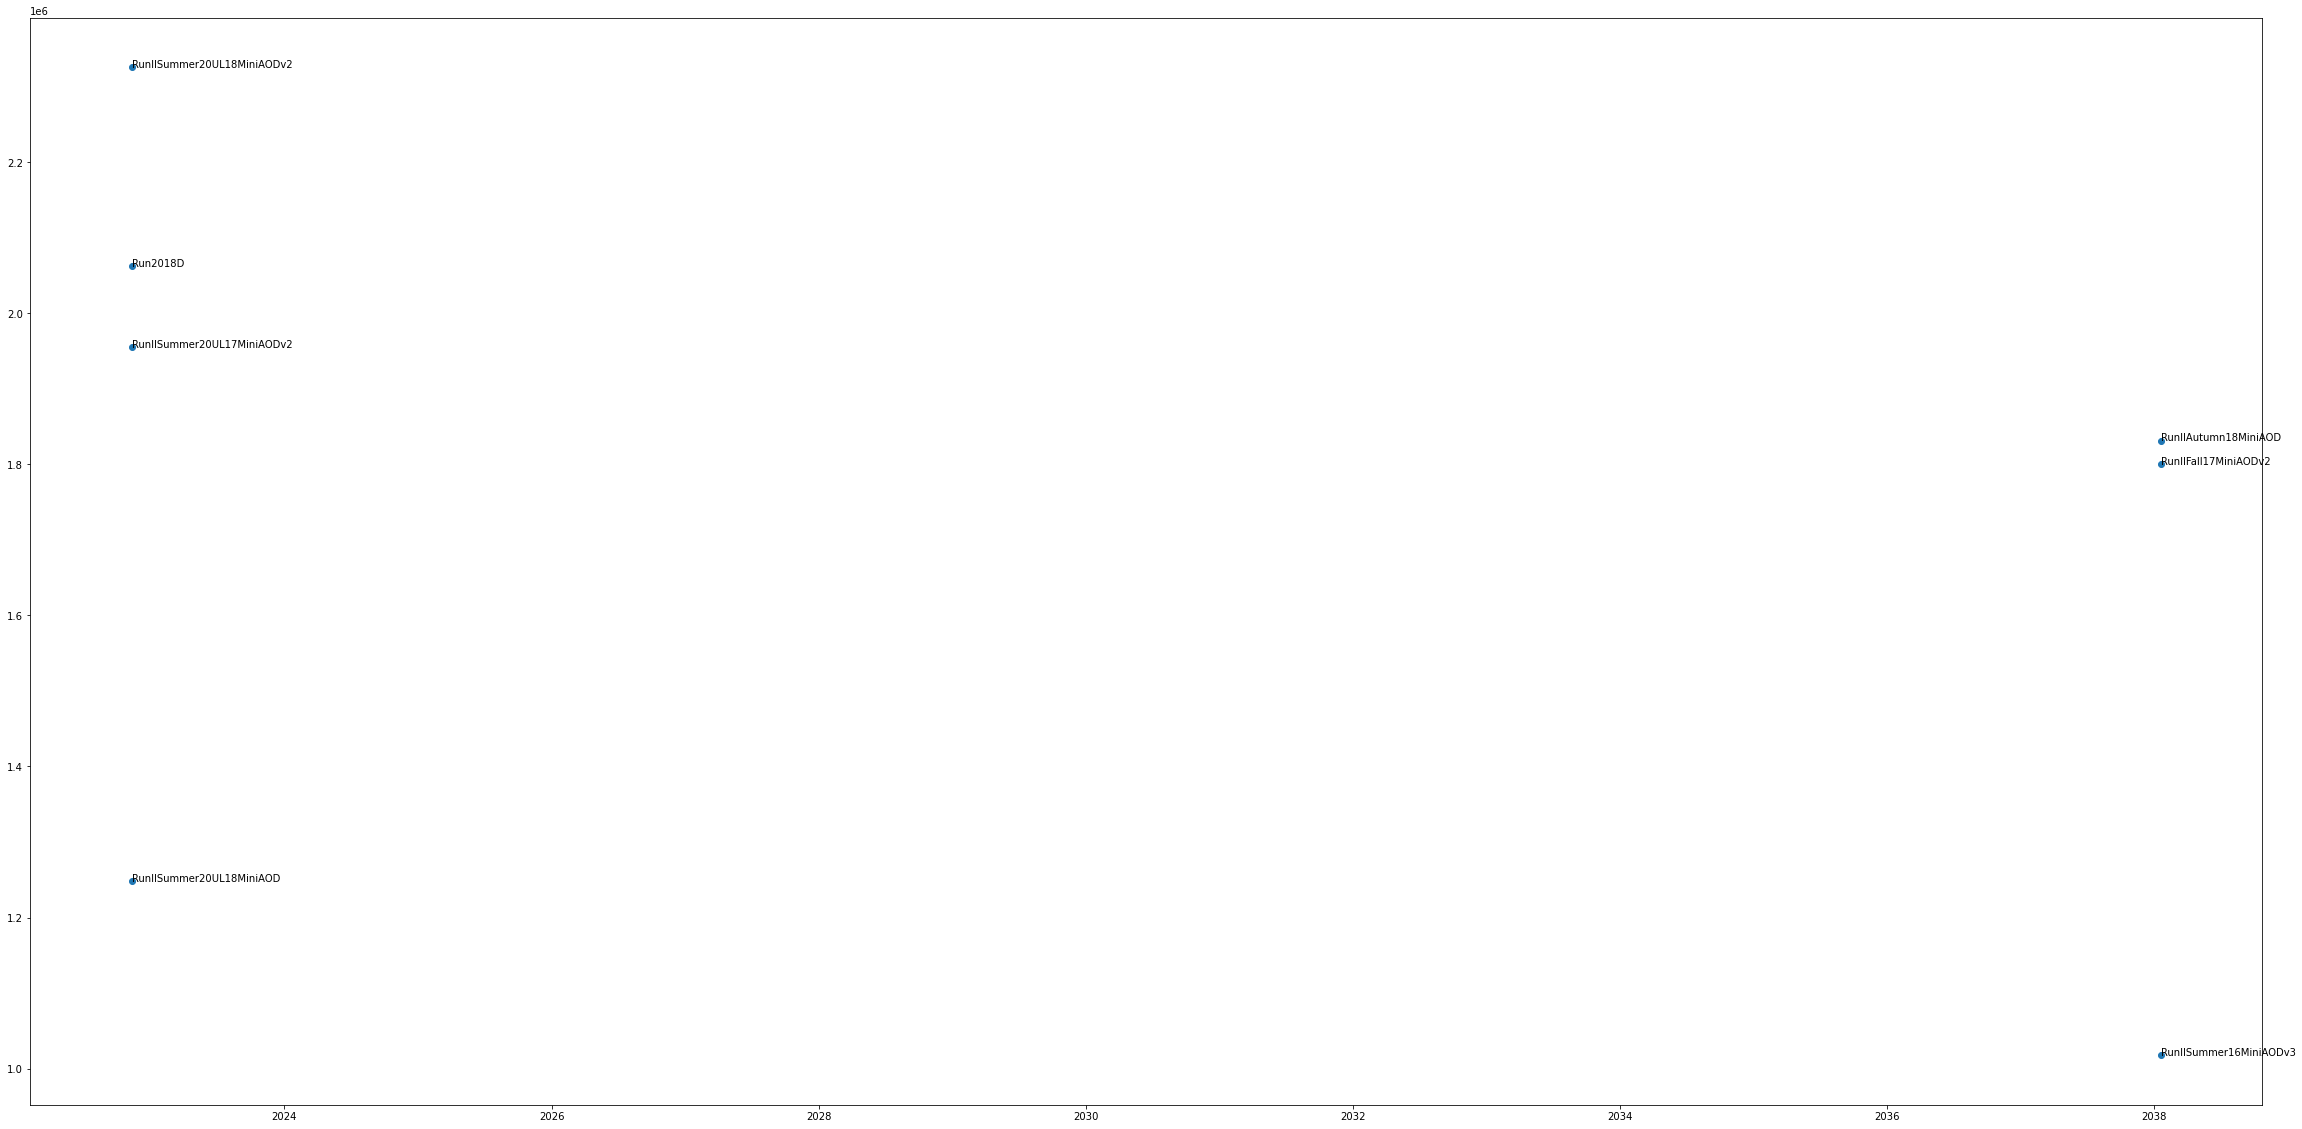

In [154]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(40, 20), dpi=80)
plt.figure(figsize=(40,20))
plt.scatter(pd_grouped['last_access'], pd_grouped['size_gb'])
for idx, row in pd_grouped.iterrows(): 
    plt.text(row['last_access'], row['size_gb'], idx)

<AxesSubplot:xlabel='campaign'>

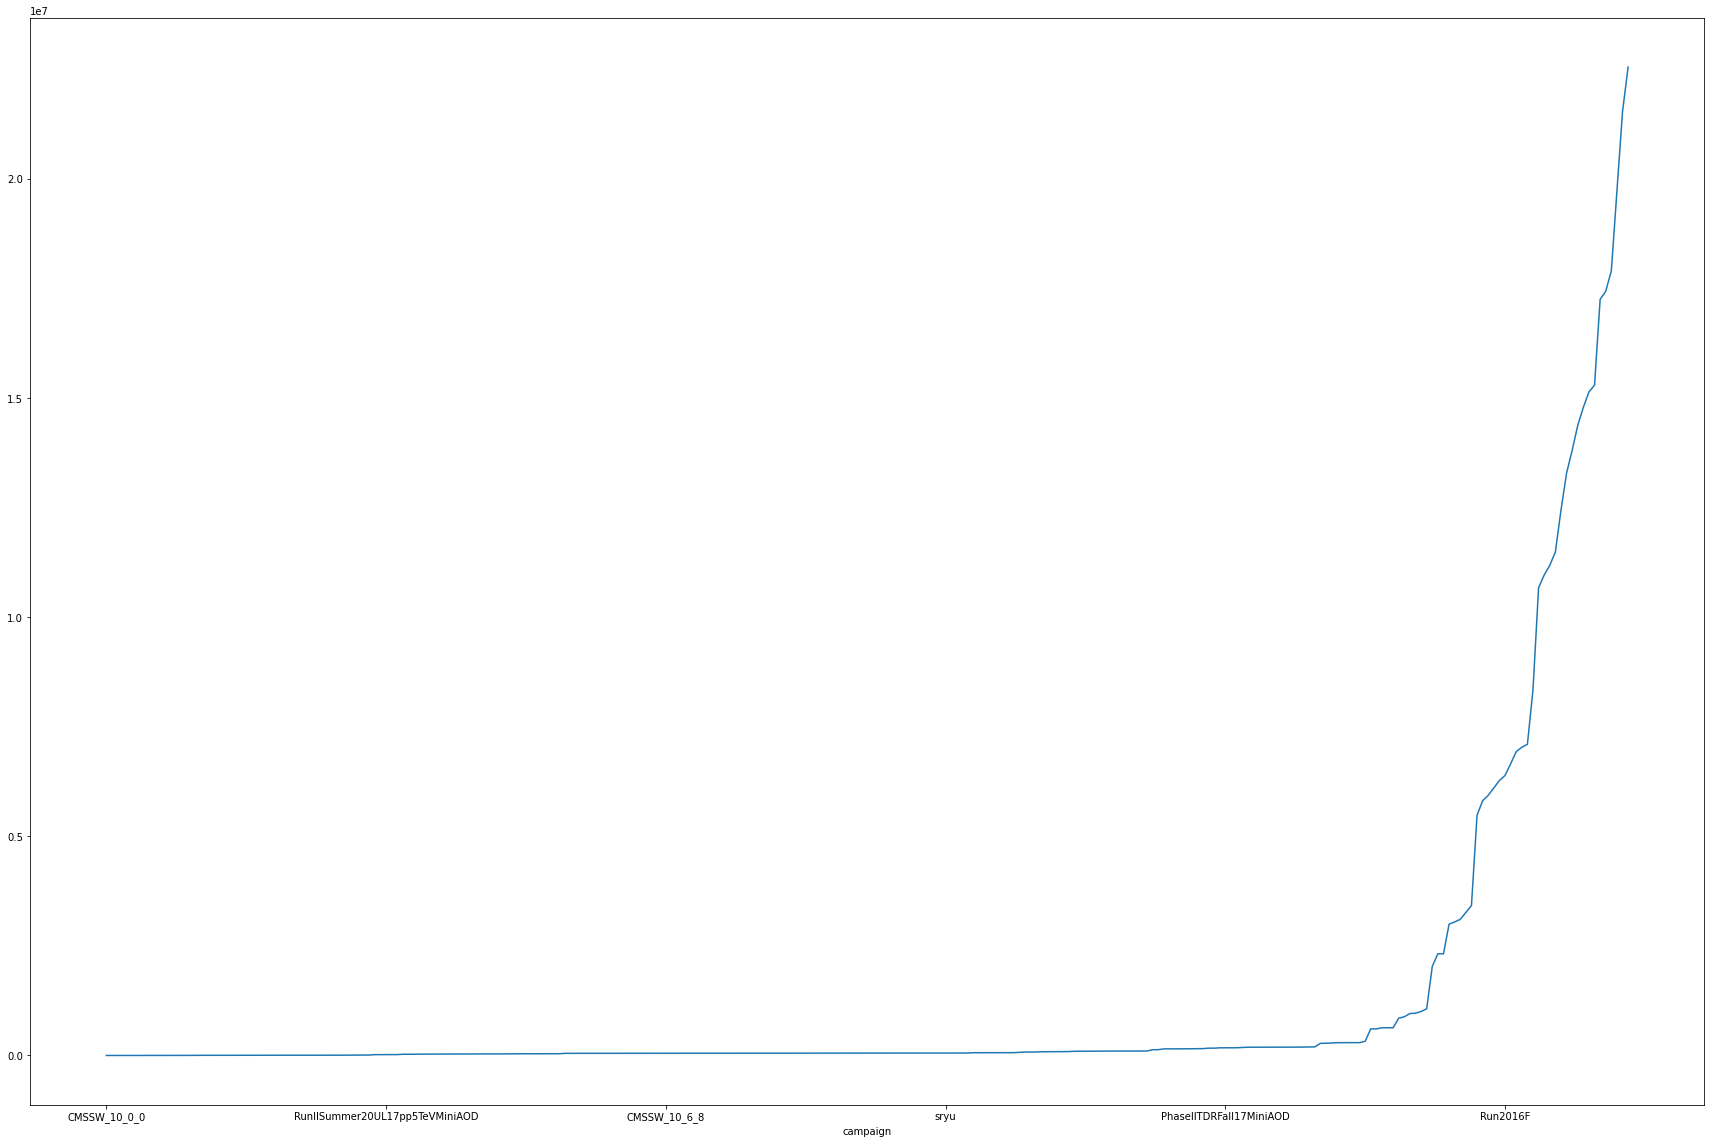

In [53]:
pd_grouped.size_gb.cumsum().plot(figsize=(30, 20))

<AxesSubplot:xlabel='campaign'>

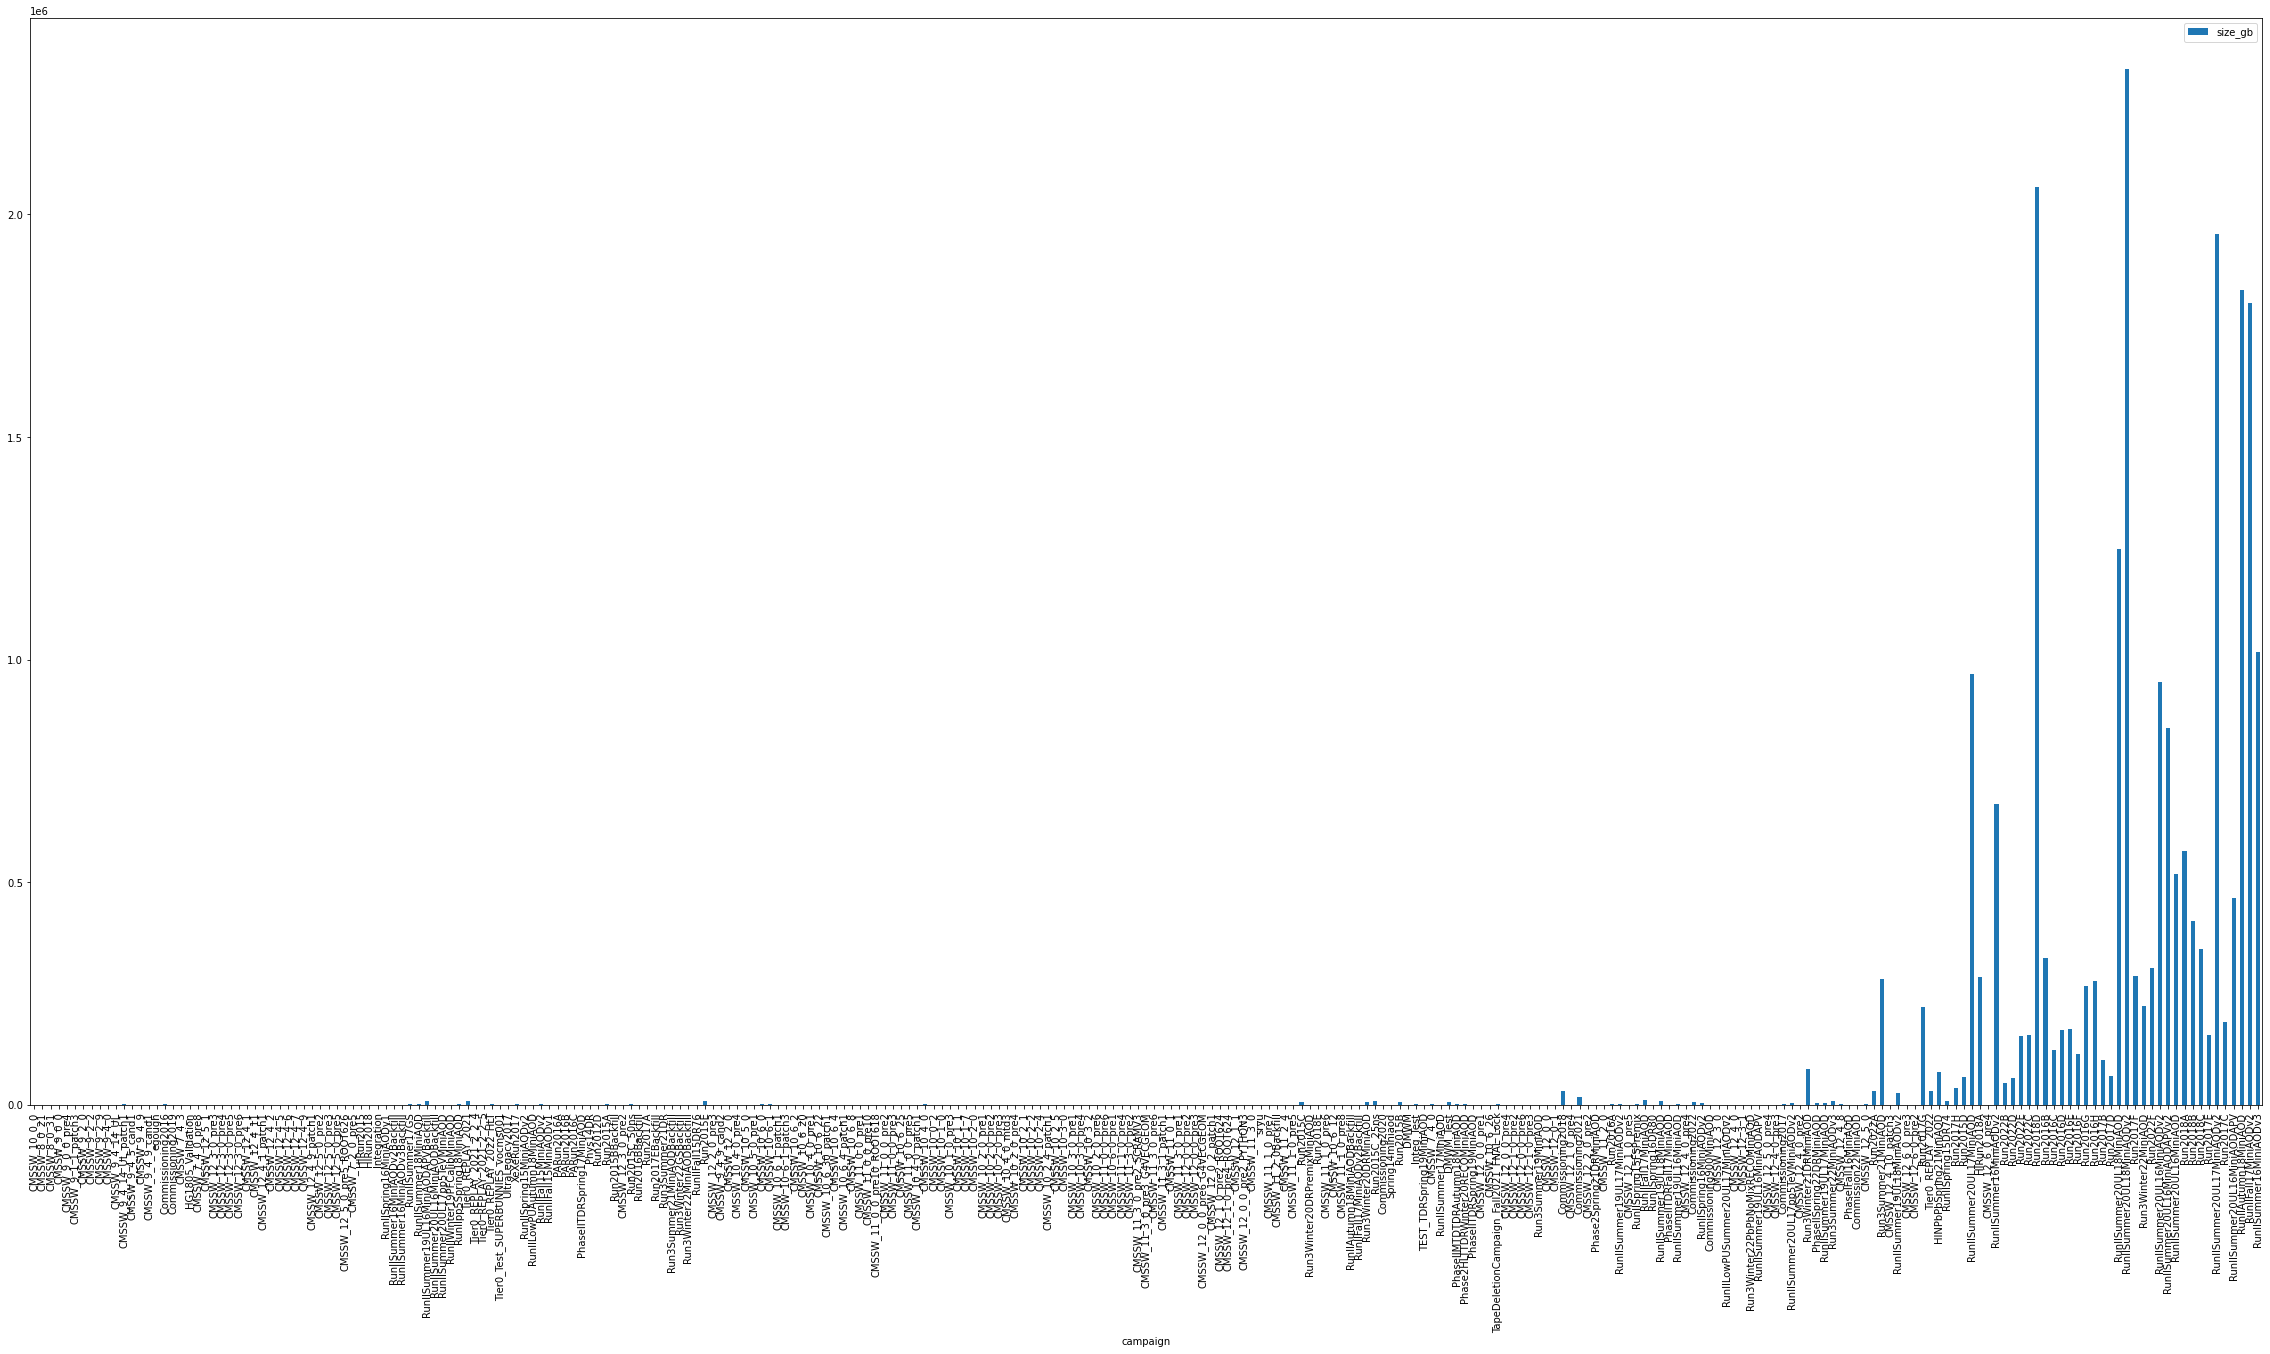

In [55]:
pd_grouped[pd_grouped.last_access != '1970-01-01'].plot.bar(y='size_gb', figsize=(40, 20))

<AxesSubplot:xlabel='last_access'>

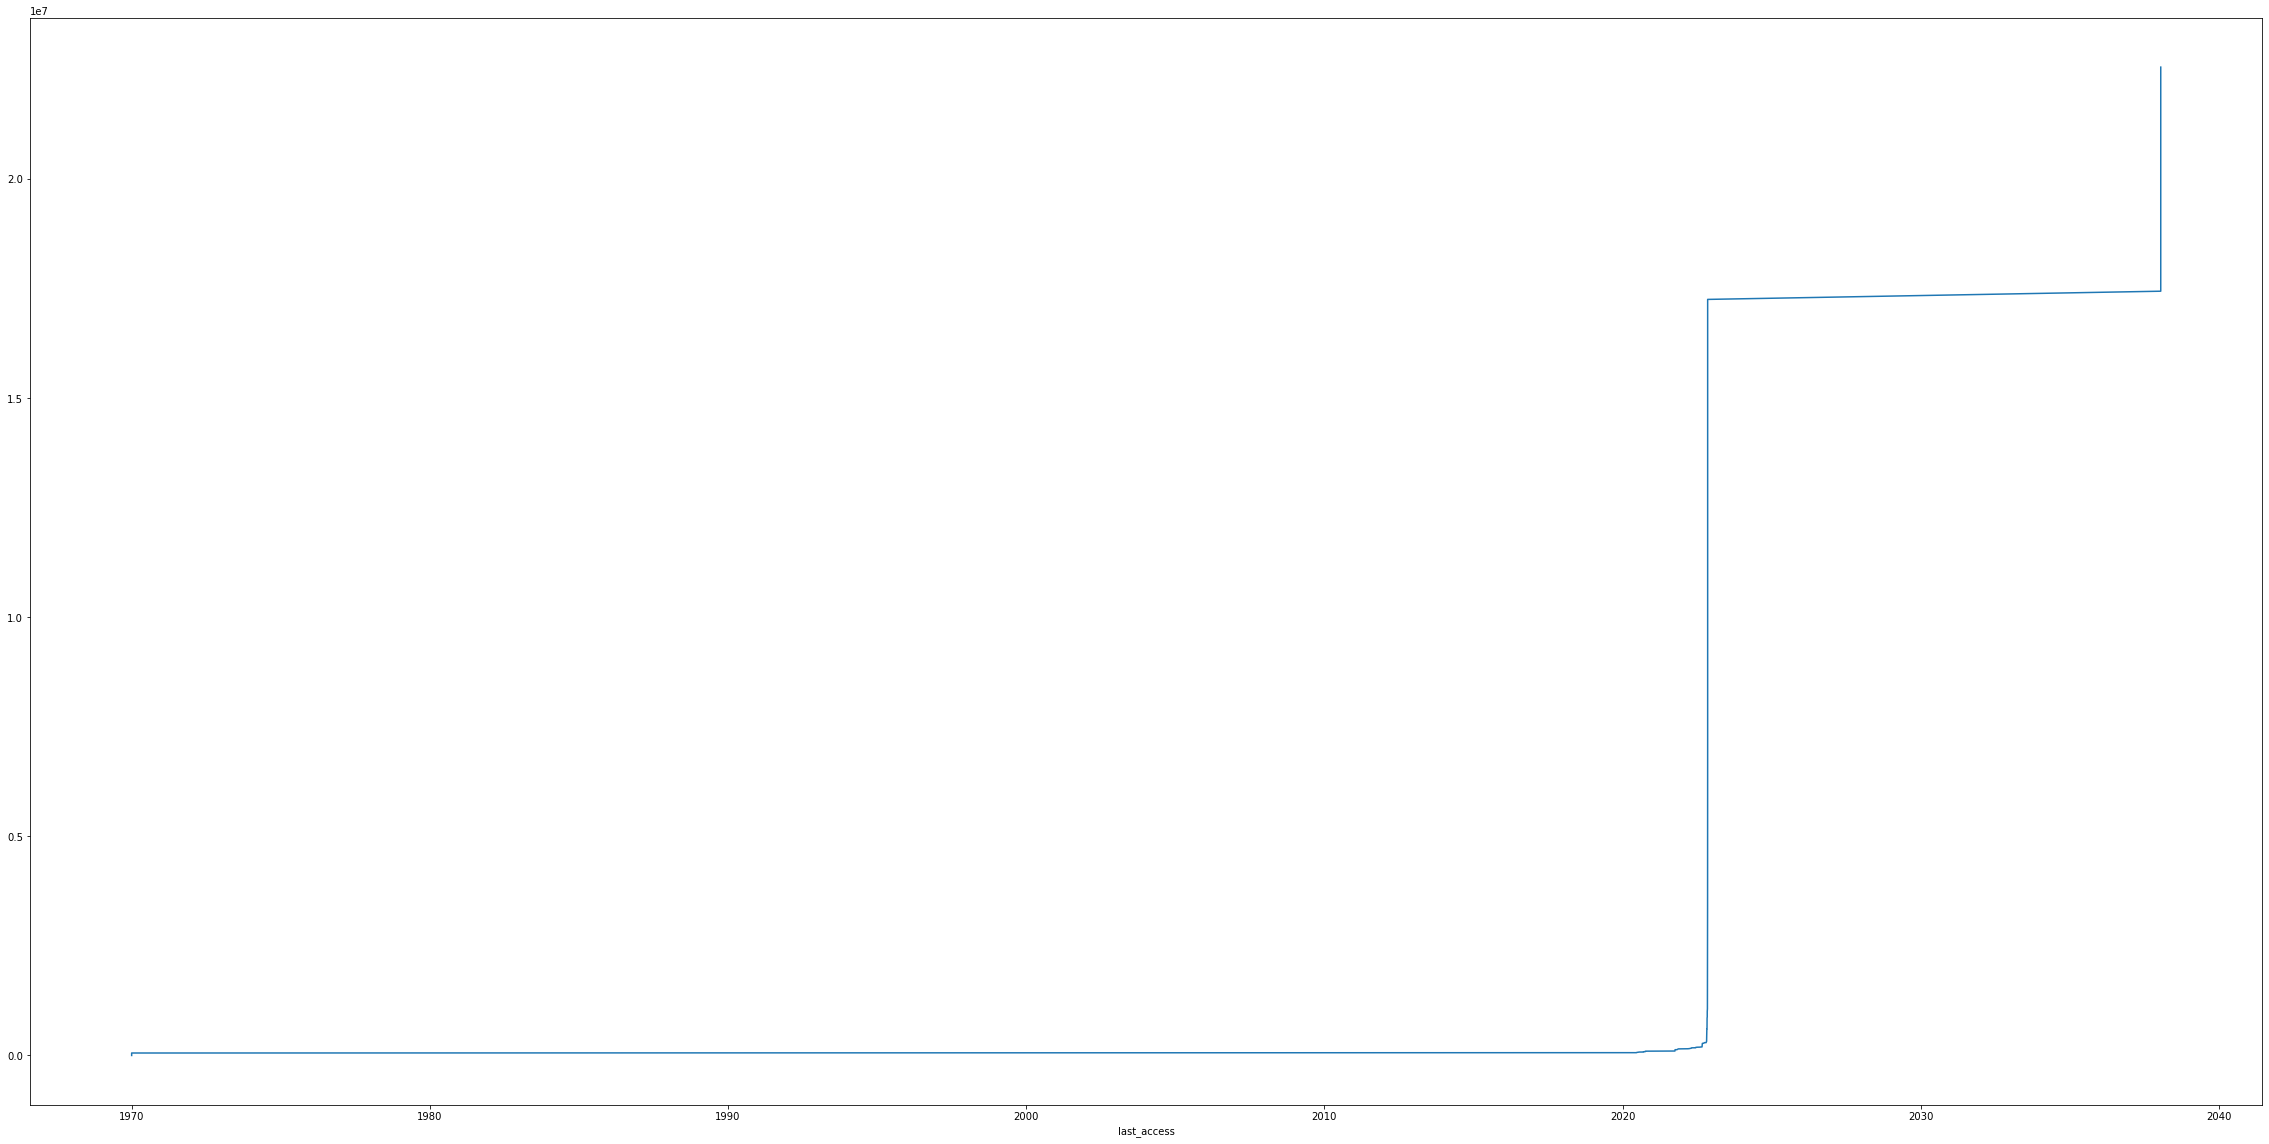

In [58]:
pd_grouped[pd_grouped.last_access != '1970-01-01'].set_index('last_access').size_gb.cumsum().plot(figsize=(40, 20))

In [ ]:
pd_grouped[pd_grouped.last_access > '2020-01-01'].set_index('last_access').size_gb.cumsum().plot(figsize=(40, 20))